In [1]:
import pandas as pd
import numpy as np

from tensorboard.backend.event_processing import event_accumulator

In [4]:
BASE_DIR = "../code/runs/"

In [5]:
def load_tf(dirname):    
    ea = event_accumulator.EventAccumulator(BASE_DIR + dirname, size_guidance={event_accumulator.SCALARS: 0})
    ea.Reload()
    dframes = {}
#     mnames = ea.Tags()['scalars']
    mnames = ["episodic_rewards", "episode_lengths"]
    
    df = pd.DataFrame()
    for n in mnames:
        values = [x.value for x in ea.Scalars(n)]
        df[n] = values
        
    return df

experiments = {
    "OC_fourrooms_12_RouteSpec_3steps_1opt",
    "OC_fourrooms_12_RouteSpec_3steps_4opt",
    "OC_fourrooms_12_RouteSpec_3steps_8opt"
}

logs = {}
for e in experiments:
    logs[e] = load_tf(e)

In [6]:
logs.keys()

dict_keys(['OC_fourrooms_12_RouteSpec_3steps_4opt', 'OC_fourrooms_12_RouteSpec_3steps_8opt', 'OC_fourrooms_12_RouteSpec_3steps_1opt'])

In [16]:
data = pd.DataFrame()
for k in logs:
    n = logs[k]["episode_lengths"].shape[0]
    o = k[-4]
    data[f"reward_{o}"] = logs[k]["episodic_rewards"]
    data[f"lengths_{o}"] = logs[k]["episode_lengths"]
    data[f"mean_lengths_{o}"] = [
        logs[k]["episode_lengths"][(i-100 if i > 100 else 0):i].mean() for i in range(n)] + [None]*(3000-n)

In [17]:
data

,reward_4,lengths_4,mean_lengths_4,reward_8,lengths_8,mean_lengths_8,reward_1,lengths_1,mean_lengths_1
0,1.0,3763.0,NaN,1.0,416.0,NaN,1.0,447.0,NaN
1,1.0,1129.0,3763.000000,1.0,264.0,416.00,1.0,17343.0,447.0
2,1.0,218.0,2446.000000,1.0,571.0,340.00,1.0,78.0,8895.0
3,1.0,1797.0,1703.333333,1.0,2127.0,417.00,1.0,300.0,5956.0
4,1.0,907.0,1726.750000,1.0,1095.0,844.50,1.0,1259.0,4542.0
...,...,...,...,...,...,...,...,...,...
2995,3.0,95.0,90.390000,3.0,72.0,92.27,NaN,NaN,NaN
2996,3.0,115.0,90.720000,3.0,73.0,91.84,NaN,NaN,NaN
2997,3.0,65.0,91.260000,3.0,91.0,91.88,NaN,NaN,NaN
2998,3.0,87.0,91.080000,3.0,94.0,91.81,NaN,NaN,NaN


<Axes: >

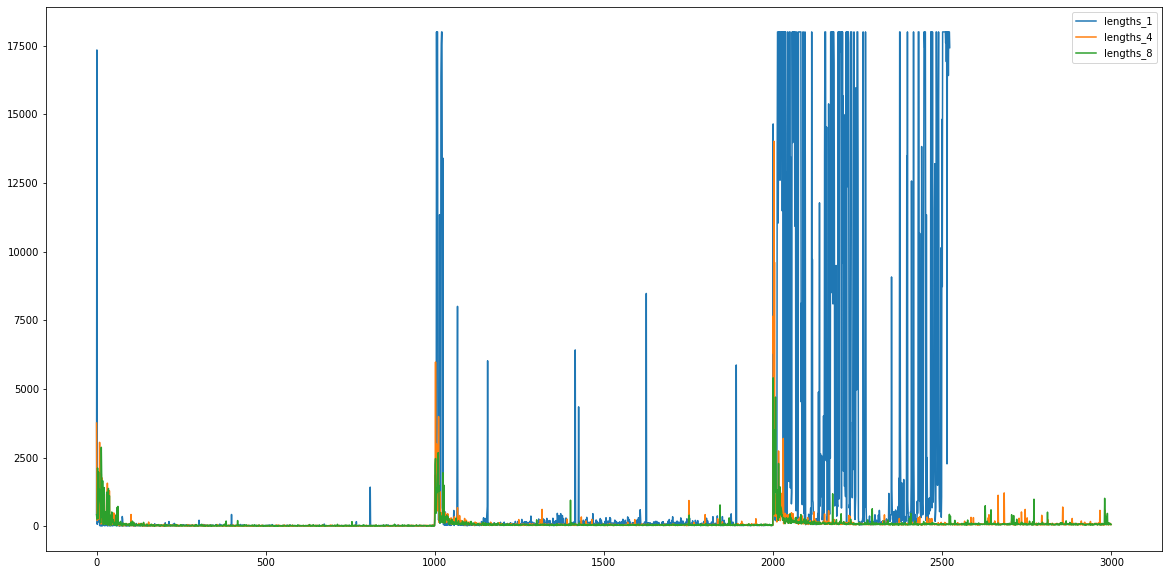

In [18]:
data[["lengths_1", "lengths_4", "lengths_8"]].plot(figsize=(20, 10))

<Axes: >

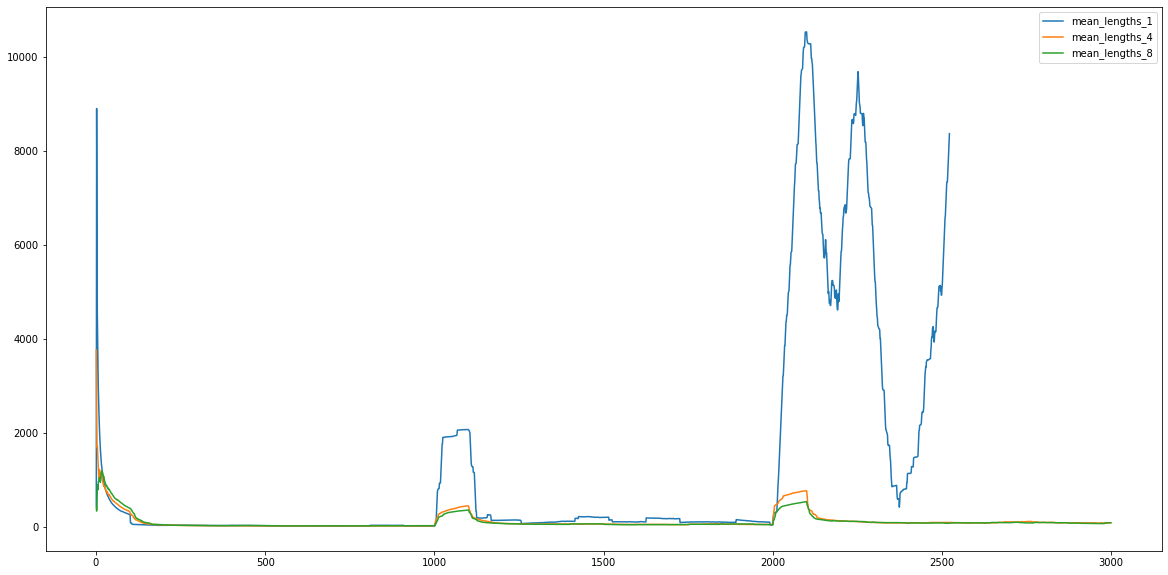

In [19]:
data[["mean_lengths_1", "mean_lengths_4", "mean_lengths_8"]].plot(figsize=(20, 10))

<Axes: >

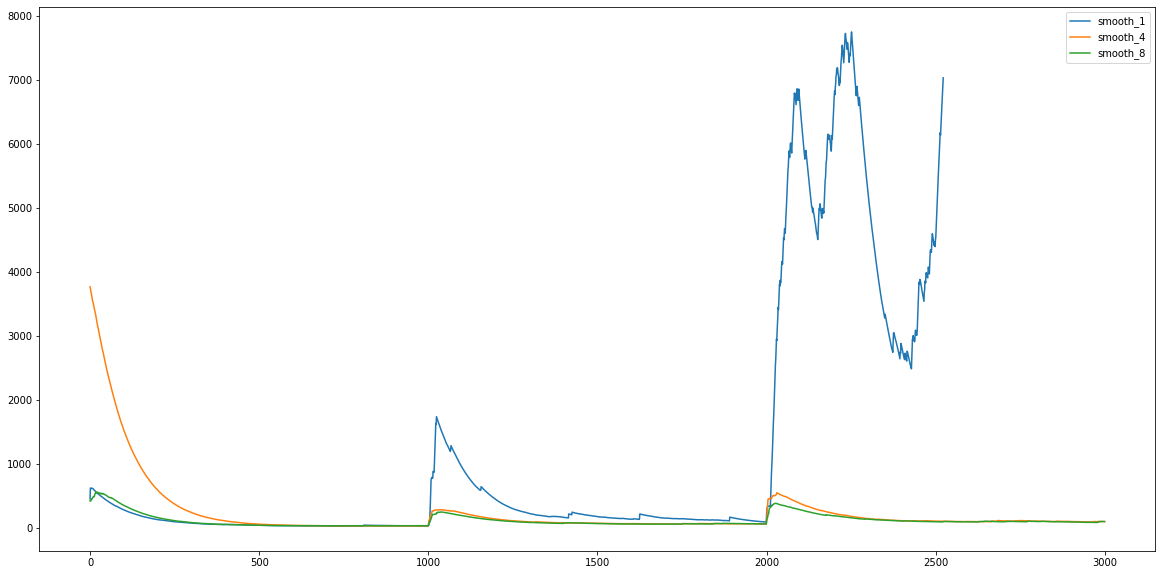

In [23]:
def smooth(scalars, weight: float):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

for o in [1,4,8]:
    data[f"smooth_{o}"] = smooth(data[f"lengths_{o}"], .99)
    
data[["smooth_1", "smooth_4", "smooth_8"]].plot(figsize=(20, 10))

In [24]:
data.to_csv("3_step_route_data.csv")